# 🎨 Polygon Colorizer with Conditional U-Net

Welcome! This notebook presents my solution to the **Ayna ML Internship Assignment**, where the task is to build a deep learning model that colors polygon shapes based on an input image and a specified color.

---

## 🧠 Problem Statement

The goal is to train a U-Net model from scratch that generates a **colored polygon image** given:
- A grayscale polygon image (e.g., triangle, square, octagon)
- A text label specifying the color (e.g., "red", "blue", "yellow")

The model should output the same polygon filled with the given color.

---

## 📦 Dataset Overview

The dataset is structured as follows:
- `training/inputs/` — Uncolored polygon images
- `training/outputs/` — Colored target images
- `training/data.json` — Maps input image and color to the output image
- Similar structure is present for `validation/`

Each sample is a triplet:
```json
{
  "input_polygon": "inputs/polygon1.png",
  "colour": "blue",
  "output_image": "outputs/polygon1_blue.png"
}


In [52]:
!pip install --upgrade wandb --quiet


<h1>Imports</h1>

In [53]:
import os
import json
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import wandb
import matplotlib.pyplot as plt
import pandas as pd

In [39]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("wandb_api")
wandb.login(key=secret_value_0)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

## Dataset Overview

Let's load the `data.json` file, which maps:
- Input polygon image paths
- Corresponding color names
- Ground truth output image paths


In [54]:
df=pd.read_json("/kaggle/input/ayna-dataset/dataset/training/data.json")
df.head()

,input_polygon,colour,output_image
0,octagon.png,cyan,cyan_octagon.png
1,square.png,purple,purple_square.png
2,hexagon.png,magenta,magenta_hexagon.png
3,square.png,magenta,magenta_square.png
4,hexagon.png,purple,purple_hexagon.png


In [55]:
dataset_dir = '/kaggle/input/ayna-dataset/dataset/training'

inputs_dir = os.path.join(dataset_dir, 'inputs')
outputs_dir = os.path.join(dataset_dir, 'outputs')
json_path=os.path.join(dataset_dir,'data.json')

with open(json_path,'r') as f:
    data=json.load(f)

print(f"Total samples in training set: {len(data)}")


Total samples in training set: 56


In [56]:
unique_shapes = {os.path.splitext(entry['input_polygon'])[0] for entry in data}
unique_colors = {entry['colour'] for entry in data}

print("Unique polygon shapes:", sorted(unique_shapes))
print("Unique colors:", sorted(unique_colors))

Unique polygon shapes: ['circle', 'diamond', 'hexagon', 'octagon', 'pentagon', 'square', 'star', 'triangle']
Unique colors: ['blue', 'cyan', 'green', 'magenta', 'orange', 'purple', 'red', 'yellow']


## Utility Functions

Define helper functions for:
- Extracting polygon names from filenames
- Visualizing input-output image pairs

In [57]:
def get_polygon_name(filename):
    return os.path.splitext(filename)[0]


Sample 1


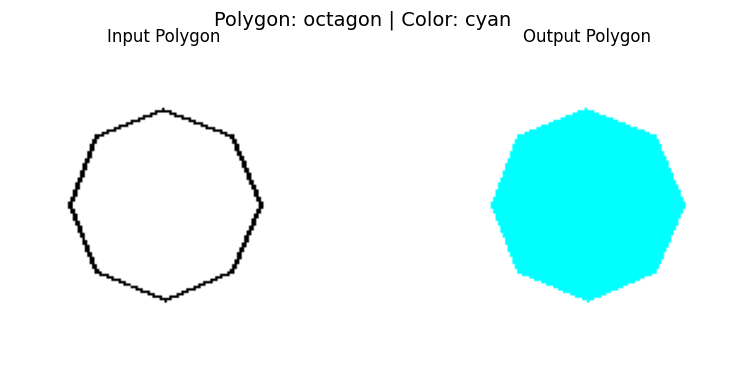


Sample 2


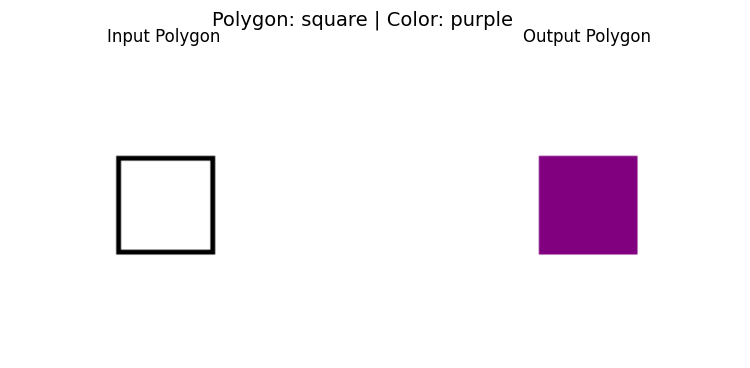


Sample 3


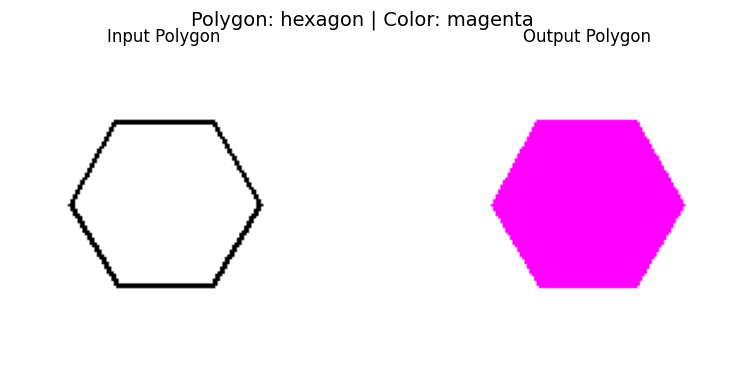

In [58]:
def visualize_sample(entry):
    input_path = os.path.join(inputs_dir, entry['input_polygon'])
    output_path = os.path.join(outputs_dir, entry['output_image'])
    color = entry['colour']
    polygon_name = get_polygon_name(entry['input_polygon'])

    input_img = Image.open(input_path)
    output_img = Image.open(output_path)

    plt.figure(figsize=(10, 4))
    plt.suptitle(f"Polygon: {polygon_name} | Color: {color}", fontsize=14)

    plt.subplot(1, 2, 1)
    plt.title('Input Polygon')
    plt.imshow(input_img)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title('Output Polygon')
    plt.imshow(output_img)
    plt.axis('off')

    plt.show()

for idx in range(3):
    print(f"\nSample {idx+1}")
    visualize_sample(data[idx])

In [59]:
train_dir = '/kaggle/input/ayna-dataset/dataset/training'
val_dir = '/kaggle/input/ayna-dataset/dataset/validation'

train_inputs_dir = os.path.join(train_dir, 'inputs')
train_outputs_dir = os.path.join(train_dir, 'outputs')
train_json = os.path.join(train_dir, 'data.json')

val_inputs_dir = os.path.join(val_dir, 'inputs')
val_outputs_dir = os.path.join(val_dir, 'outputs')
val_json = os.path.join(val_dir, 'data.json')

In [60]:
def get_unique_colors(json_path):
    with open(json_path, 'r') as f:
        data = json.load(f)
    unique_colors = set(entry['colour'] for entry in data)
    return sorted(unique_colors)

ALL_COLORS = get_unique_colors(train_json)
COLOR_DIM = len(ALL_COLORS)
print(f"Unique colors: {ALL_COLORS}")
print(f"Color dimension for one-hot: {COLOR_DIM}")

Unique colors: ['blue', 'cyan', 'green', 'magenta', 'orange', 'purple', 'red', 'yellow']
Color dimension for one-hot: 8


In [61]:
def color_to_onehot(color):
    idx = ALL_COLORS.index(color)
    vec = torch.zeros(COLOR_DIM)
    vec[idx] = 1.0
    return vec

## Image Transformations

In [62]:
img_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  
])

## Custom Dataset Class

We implement a custom PyTorch `Dataset` class that:
- Loads image-color pairs
- Applies transformations
- Returns input image, one-hot color vector, and target image

In [63]:
class PolygonDataset(Dataset):
    def __init__(self, json_path, inputs_dir, outputs_dir, transform=None):
        with open(json_path, 'r') as f:
            self.data = json.load(f)
        self.inputs_dir = inputs_dir
        self.outputs_dir = outputs_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        entry = self.data[idx]
        input_path = os.path.join(self.inputs_dir, entry['input_polygon'])
        output_path = os.path.join(self.outputs_dir, entry['output_image'])
        color = entry['colour']

        input_img = Image.open(input_path).convert('RGB')
        output_img = Image.open(output_path).convert('RGB')

        if self.transform:
            input_img = self.transform(input_img)
            output_img = self.transform(output_img)

        color_onehot = color_to_onehot(color)
        return input_img, color_onehot, output_img

train_dataset = PolygonDataset(train_json, train_inputs_dir, train_outputs_dir, img_transform)
val_dataset = PolygonDataset(val_json, val_inputs_dir, val_outputs_dir, img_transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

## U-Net Architecture Components

Define the basic building blocks for our Conditional U-Net:
- `DoubleConv`: Two convolutional layers with optional dropout
- (Next cells will continue with encoder/decoder blocks)


In [64]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, use_dropout=False):
        super().__init__()
        layers = [
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.1, inplace=True)
        ]
        if use_dropout:
            layers.append(nn.Dropout(0.3))
        self.conv = nn.Sequential(*layers)

    def forward(self, x):
        return self.conv(x)


class ConditionalUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, color_dim=8): 
        super().__init__()
        self.color_dim = color_dim

        # Encoder
        self.enc1 = DoubleConv(in_channels + color_dim, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.enc4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        # Bottleneck with dropout
        self.bottleneck = DoubleConv(512, 1024, use_dropout=True)

        # Decoder with dropout
        self.up5 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec5 = DoubleConv(1024, 512, use_dropout=True)
        self.up6 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec6 = DoubleConv(512, 256)
        self.up7 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec7 = DoubleConv(256, 128)
        self.up8 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec8 = DoubleConv(128, 64)

        self.final_conv = nn.Conv2d(64, out_channels, 1)
        self.sigmoid = nn.Sigmoid()

        self._initialize_weights()

    def forward(self, x, color_onehot):
        color_expanded = color_onehot.unsqueeze(2).unsqueeze(3).expand(-1, -1, x.shape[2], x.shape[3])
        x = torch.cat([x, color_expanded], dim=1)

        # Encoder
        e1 = self.enc1(x)
        p1 = self.pool1(e1)
        e2 = self.enc2(p1)
        p2 = self.pool2(e2)
        e3 = self.enc3(p2)
        p3 = self.pool3(e3)
        e4 = self.enc4(p3)
        p4 = self.pool4(e4)

        # Bottleneck
        b = self.bottleneck(p4)

        # Decoder with skip connections
        d5 = self.up5(b)
        d5 = torch.cat([d5, e4], dim=1)
        d5 = self.dec5(d5)
        d6 = self.up6(d5)
        d6 = torch.cat([d6, e3], dim=1)
        d6 = self.dec6(d6)
        d7 = self.up7(d6)
        d7 = torch.cat([d7, e2], dim=1)
        d7 = self.dec7(d7)
        d8 = self.up8(d7)
        d8 = torch.cat([d8, e1], dim=1)
        d8 = self.dec8(d8)

        out = self.final_conv(d8)
        return self.sigmoid(out)

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)


## Training Setup

Setup:
- Device (CPU/GPU)
- Optimizer and learning rate scheduler
- Loss function (e.g., CrossEntropyLoss, MSELoss, etc.)


In [65]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
import copy

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = ConditionalUNet().to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

criterion = nn.MSELoss() 

wandb.init(project="polygon-colorizer-kaggle", config={
    "learning_rate": 1e-3,
    "epochs": 50,
    "batch_size": 16,
    "weight_decay": 1e-5
})

# Scheduler: Reduce LR on plateau
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

# Early stopping parameters
best_val_loss = float('inf')
patience = 10
counter = 0
best_model_wts = copy.deepcopy(model.state_dict())  # To save best model


cuda


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


## Model Training

Train the Conditional U-Net on the polygon-color dataset.

Track:
- Training loss
- Validation loss
- Learning rate adjustment

Use **Weights & Biases (wandb)** for logging.


In [66]:
num_epochs = wandb.config.epochs
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for inputs, colors, targets in train_loader:
        inputs, colors, targets = inputs.to(device), colors.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs, colors)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, colors, targets in val_loader:
            inputs, colors, targets = inputs.to(device), colors.to(device), targets.to(device)
            outputs = model(inputs, colors)
            val_loss += criterion(outputs, targets).item()

    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)

    # Log to W&B
    wandb.log({
        "train_loss": avg_train_loss,
        "val_loss": avg_val_loss,
        "epoch": epoch,
        "lr": optimizer.param_groups[0]['lr']
    })

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}")

    # Step scheduler
    scheduler.step(avg_val_loss)

    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_wts = copy.deepcopy(model.state_dict())
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

# Load best model
model.load_state_dict(best_model_wts)


Epoch 1/50 - Train Loss: 0.3923 - Val Loss: 0.4981
Epoch 2/50 - Train Loss: 0.2633 - Val Loss: 0.9155
Epoch 3/50 - Train Loss: 0.2167 - Val Loss: 0.2391
Epoch 4/50 - Train Loss: 0.1889 - Val Loss: 0.2459
Epoch 5/50 - Train Loss: 0.1695 - Val Loss: 0.1822
Epoch 6/50 - Train Loss: 0.1545 - Val Loss: 0.1546
Epoch 7/50 - Train Loss: 0.1381 - Val Loss: 0.1534
Epoch 8/50 - Train Loss: 0.1412 - Val Loss: 0.1290
Epoch 9/50 - Train Loss: 0.1319 - Val Loss: 0.1120
Epoch 10/50 - Train Loss: 0.1222 - Val Loss: 0.1057
Epoch 11/50 - Train Loss: 0.1208 - Val Loss: 0.0839
Epoch 12/50 - Train Loss: 0.1152 - Val Loss: 0.0824
Epoch 13/50 - Train Loss: 0.1130 - Val Loss: 0.0827
Epoch 14/50 - Train Loss: 0.1126 - Val Loss: 0.0802
Epoch 15/50 - Train Loss: 0.1091 - Val Loss: 0.0803
Epoch 16/50 - Train Loss: 0.1046 - Val Loss: 0.0800
Epoch 17/50 - Train Loss: 0.1083 - Val Loss: 0.0778
Epoch 18/50 - Train Loss: 0.1046 - Val Loss: 0.0755
Epoch 19/50 - Train Loss: 0.1021 - Val Loss: 0.0751
Epoch 20/50 - Train L

<All keys matched successfully>

In [67]:
torch.save(model.state_dict(), "unet_polygon_model.pth")
wandb.finish()

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▅▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▅█▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,49
lr,0.001
train_loss,0.09696
val_loss,0.06881


## Inference & Evaluation

Load the trained model and run inference on new polygon-color inputs. Visualize results and compare predicted outputs against ground truth.


In [68]:
model = ConditionalUNet()
model.load_state_dict(torch.load("unet_polygon_model.pth"))
model.to(device)
model.eval()
# Example inference function
def infer(model, input_img_path, color_name):
    input_img = Image.open(input_img_path).convert('RGB')
    input_tensor = img_transform(input_img).unsqueeze(0).to(device)
    color_onehot = color_to_onehot(color_name).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor, color_onehot)
    output_img = transforms.ToPILImage()(output.squeeze(0).cpu())

    # Visualize
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Input Polygon")
    plt.imshow(input_img)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title(f"Generated Output ({color_name})")
    plt.imshow(output_img)
    plt.axis('off')
    plt.show()


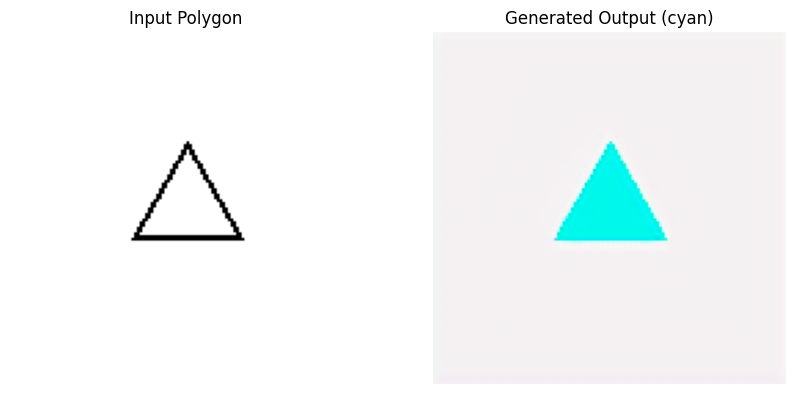

In [69]:
example_input = os.path.join(val_inputs_dir, 'triangle.png') 
example_color = 'cyan'  
infer(model, example_input, example_color)